### Assignment number = 2
### Name = Varun Vashishtha
### Roll number = 2022201061

### Set up a modular codebase for training a CNN (LeNet) on the task of handwritten digit recognition. You should have clear functional separation between the data (dataset and dataloader), model (nn.Module), and trainer (train/test epoch loops). Implement logging: using Weights & Biases is highly recommended, alternatively, create your own plots using other plotting libraries. Log the training and evaluation losses and accuracies at every epoch, show the plots for at least one training and evaluation run.

In [9]:
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wandb.init(project='digit-recognition')

In [4]:
# Define the LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Define the data handling module
def get_data_loaders(batch_size=128):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [11]:
def test_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_loss / len(test_loader)
    accuracy = correct / total
    wandb.log({"Test Accuracy": accuracy, "Test Loss": test_loss})
    print(f"Test Loss: {test_loss}, Test Accuracy: {accuracy}")
    return test_loss, accuracy


In [12]:
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=5):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_accuracy})
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")

        test_loss, test_accuracy = test_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss (matplotlib)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy (matplotlib)')
    plt.legend()
    plt.show()

    return train_losses, test_losses



In [15]:
batch_size = 128
train_loader, test_loader = get_data_loaders(batch_size=batch_size)

model = LeNet().to(device)
wandb.watch(model)

[]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.2912557763752462, Train Accuracy: 0.9151166666666667


 20%|██        | 1/5 [00:21<01:25, 21.25s/it]

Test Loss: 0.07018866348286643, Test Accuracy: 0.9792
Epoch 2, Train Loss: 0.07244570354428659, Train Accuracy: 0.9777333333333333


 40%|████      | 2/5 [00:40<01:01, 20.36s/it]

Test Loss: 0.04410323675845667, Test Accuracy: 0.9856
Epoch 3, Train Loss: 0.05119513673807131, Train Accuracy: 0.9838166666666667


 60%|██████    | 3/5 [01:00<00:40, 20.07s/it]

Test Loss: 0.05116110598768662, Test Accuracy: 0.9825
Epoch 4, Train Loss: 0.03819063509345801, Train Accuracy: 0.9881


 80%|████████  | 4/5 [01:25<00:21, 21.75s/it]

Test Loss: 0.029678233230340623, Test Accuracy: 0.9901
Epoch 5, Train Loss: 0.032234067973027476, Train Accuracy: 0.9896333333333334


100%|██████████| 5/5 [01:44<00:00, 20.81s/it]

Test Loss: 0.034829807339646544, Test Accuracy: 0.9881


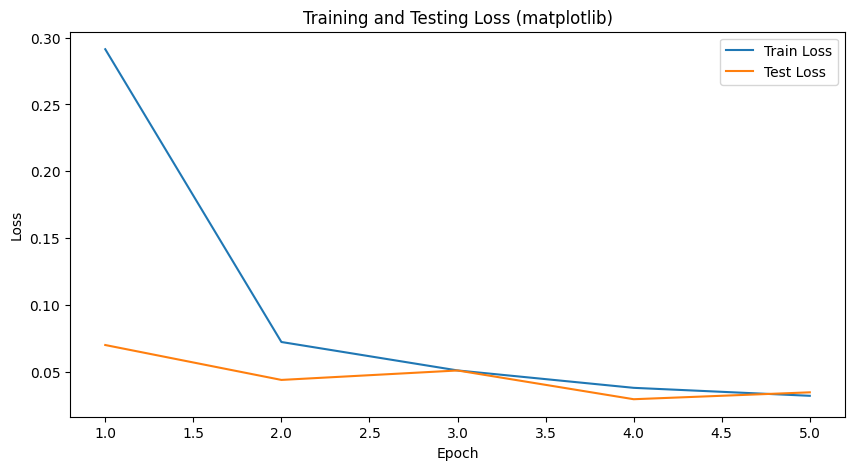

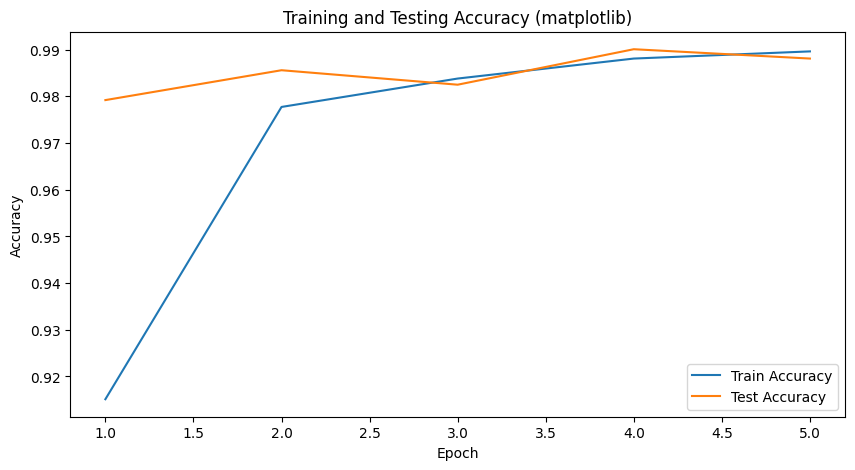

In [16]:
num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)

Weights and Baises

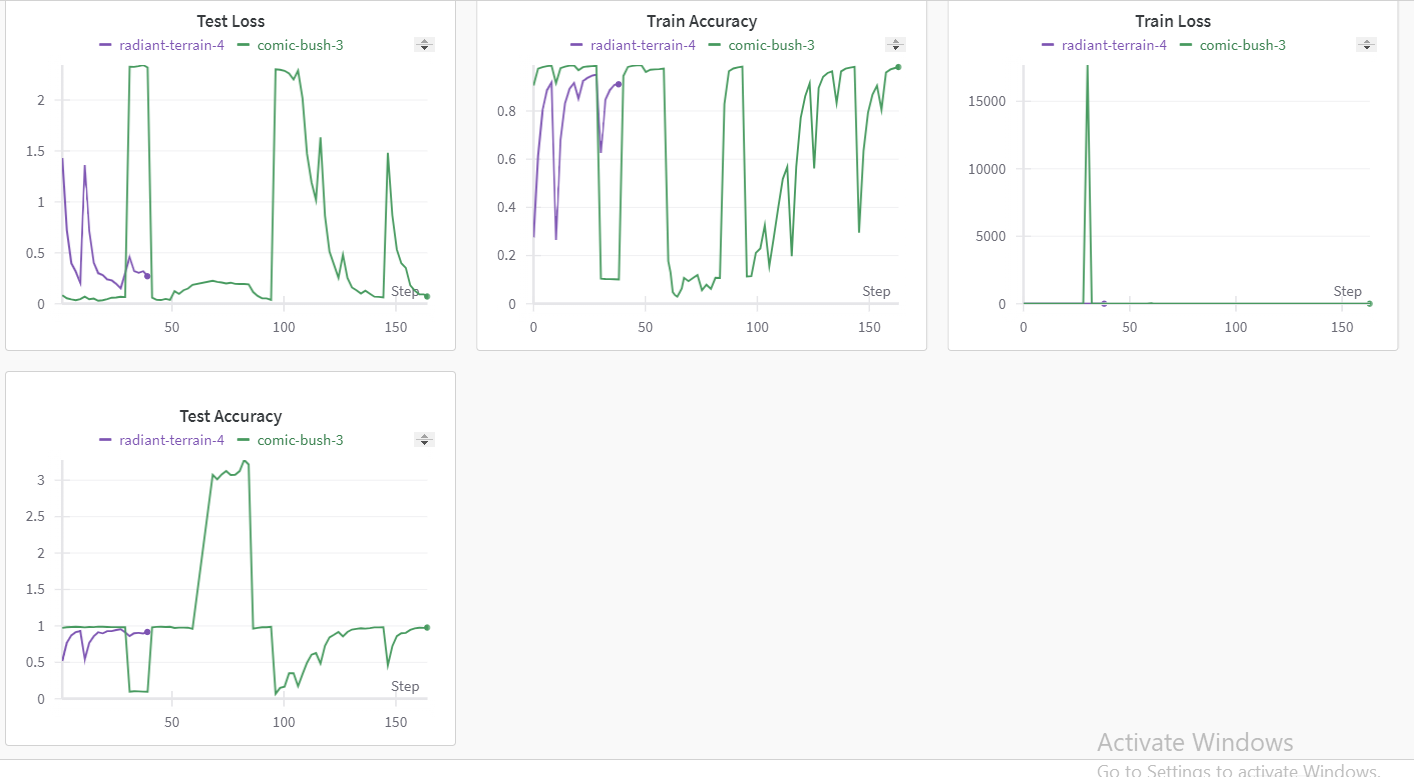

Show the results for 6 different settings of hyperparameters. You may want to change the batch size,
learning rate, and optimizer. Explain the trends in classification accuracy that you observe. Which hyperparameters
are most important?

Batch size didn't imapct that much, learning rate impacted the most, also optimizer use didn,t impacted that much, but changing loss function to mse impacted a lot.

In [ ]:
batch_size = 128
train_loader, test_loader = get_data_loaders(batch_size=batch_size)

model = LeNet().to(device)
wandb.watch(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.11762598822556579, Train Accuracy: 0.9692833333333334


 20%|██        | 1/5 [00:20<01:20, 20.16s/it]

Test Loss: 0.045683240813433036, Test Accuracy: 0.9858
Epoch 2, Train Loss: 0.061653477090126925, Train Accuracy: 0.98195


 40%|████      | 2/5 [00:40<01:00, 20.18s/it]

Test Loss: 0.05930812507749924, Test Accuracy: 0.983
Epoch 3, Train Loss: 0.05215730697665213, Train Accuracy: 0.9848833333333333


 60%|██████    | 3/5 [01:02<00:42, 21.08s/it]

Test Loss: 0.06118554823018413, Test Accuracy: 0.9829
Epoch 4, Train Loss: 0.05053009144884389, Train Accuracy: 0.9860166666666667


 80%|████████  | 4/5 [01:24<00:21, 21.40s/it]

Test Loss: 0.06816453813822775, Test Accuracy: 0.9812
Epoch 5, Train Loss: 0.0478843306574766, Train Accuracy: 0.9873


100%|██████████| 5/5 [01:46<00:00, 21.32s/it]

Test Loss: 0.06559602373914758, Test Accuracy: 0.9823


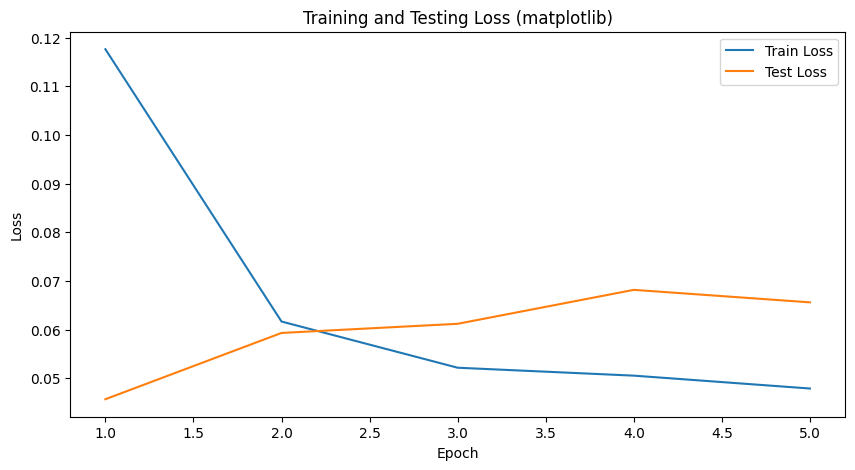

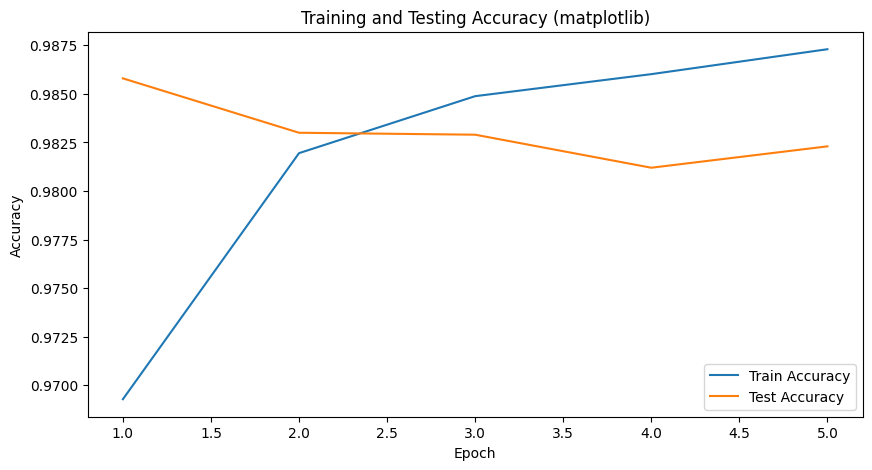

In [17]:
num_epochs = 5
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)

In [ ]:
batch_size = 128
train_loader, test_loader = get_data_loaders(batch_size=batch_size)

model = LeNet().to(device)
wandb.watch(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Loss: 17687.68831074665, Train Accuracy: 0.10385


 20%|██        | 1/5 [00:19<01:18, 19.68s/it]

Test Loss: 2.3270218070549302, Test Accuracy: 0.0974
Epoch 2, Train Loss: 2.3403543373669136, Train Accuracy: 0.10256666666666667


 40%|████      | 2/5 [00:38<00:57, 19.16s/it]

Test Loss: 2.325400895710233, Test Accuracy: 0.1032
Epoch 3, Train Loss: 2.350494367989904, Train Accuracy: 0.10216666666666667


 60%|██████    | 3/5 [00:57<00:38, 19.18s/it]

Test Loss: 2.332582129707819, Test Accuracy: 0.1009
Epoch 4, Train Loss: 2.348337905493372, Train Accuracy: 0.10178333333333334


 80%|████████  | 4/5 [01:16<00:18, 18.88s/it]

Test Loss: 2.3437398596654964, Test Accuracy: 0.0982
Epoch 5, Train Loss: 2.3464202286083817, Train Accuracy: 0.10041666666666667


100%|██████████| 5/5 [01:36<00:00, 19.29s/it]

Test Loss: 2.3186600268641606, Test Accuracy: 0.0958


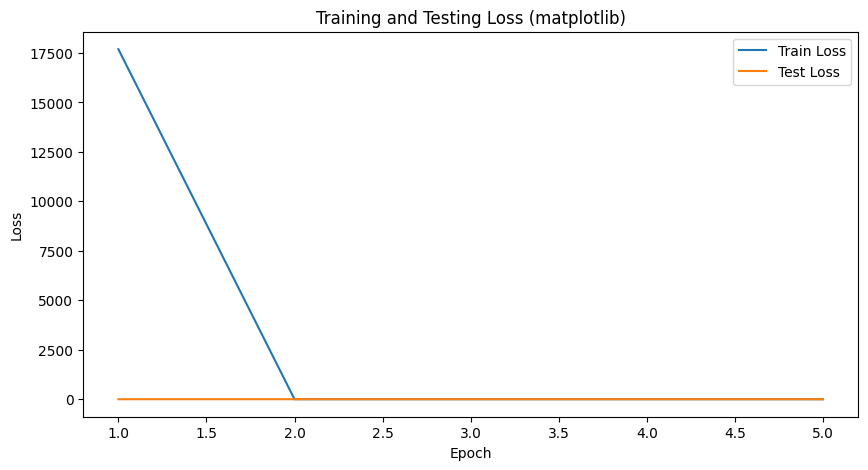

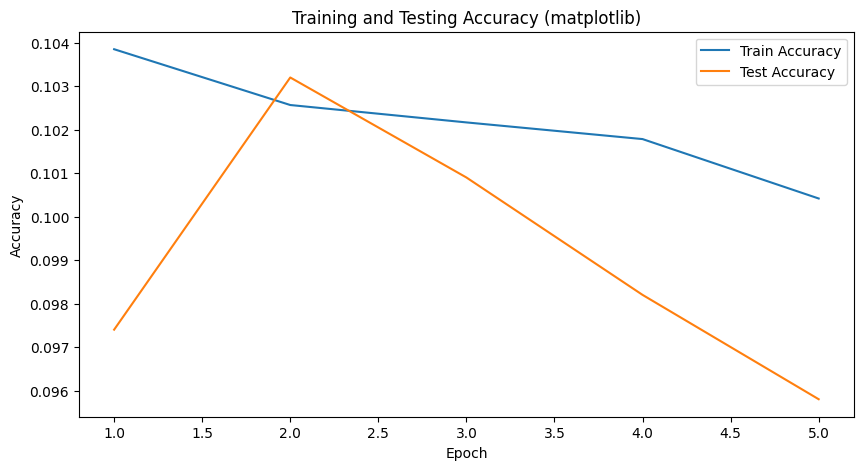

In [19]:
num_epochs = 5
learning_rate = 1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)

In [20]:
batch_size = 32
train_loader, test_loader = get_data_loaders(batch_size=batch_size)

model = LeNet().to(device)
wandb.watch(model)

[]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.17439246947731202, Train Accuracy: 0.9454


 20%|██        | 1/5 [00:26<01:44, 26.07s/it]

Test Loss: 0.06030854961936014, Test Accuracy: 0.9812
Epoch 2, Train Loss: 0.05552296121390536, Train Accuracy: 0.9828166666666667


 40%|████      | 2/5 [00:50<01:15, 25.00s/it]

Test Loss: 0.038431820019526546, Test Accuracy: 0.9865
Epoch 3, Train Loss: 0.042169173041874695, Train Accuracy: 0.9870333333333333


 60%|██████    | 3/5 [01:12<00:47, 23.91s/it]

Test Loss: 0.0363159369344866, Test Accuracy: 0.9881
Epoch 4, Train Loss: 0.033152435552905084, Train Accuracy: 0.9897333333333334


 80%|████████  | 4/5 [01:35<00:23, 23.42s/it]

Test Loss: 0.047737622056456964, Test Accuracy: 0.9849
Epoch 5, Train Loss: 0.02806048403144135, Train Accuracy: 0.9908833333333333


100%|██████████| 5/5 [01:58<00:00, 23.70s/it]

Test Loss: 0.03731099752465412, Test Accuracy: 0.988


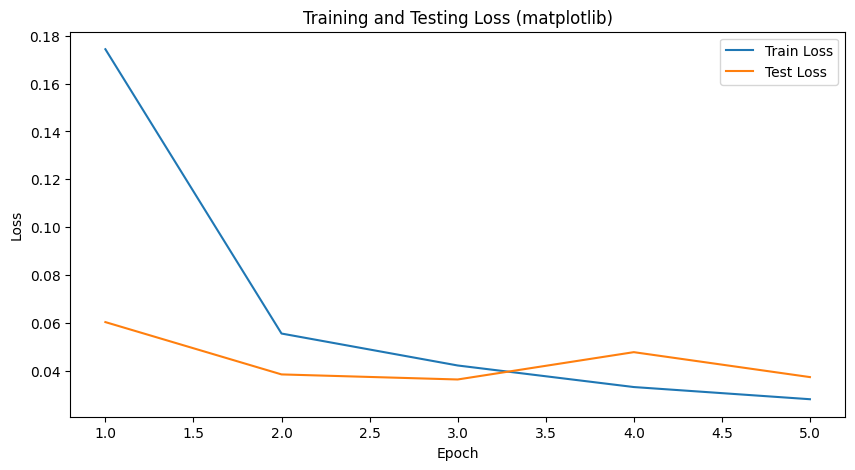

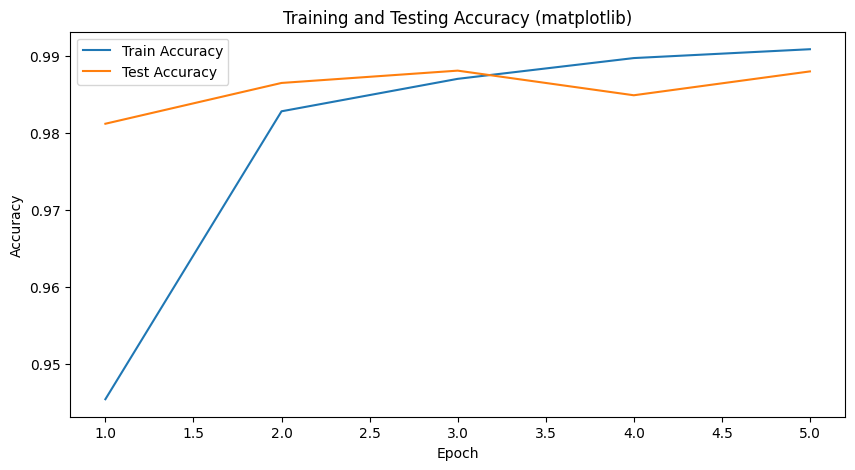

In [21]:
num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)

In [ ]:
batch_size = 128
train_loader, test_loader = get_data_loaders(batch_size=batch_size)

model = LeNet().to(device)
wandb.watch(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.15108224537391993, Train Accuracy: 0.9618333333333333


 20%|██        | 1/5 [00:22<01:30, 22.71s/it]

Test Loss: 0.12346347905964974, Test Accuracy: 0.9711
Epoch 2, Train Loss: 0.12361667936037798, Train Accuracy: 0.9713333333333334


 40%|████      | 2/5 [00:45<01:08, 22.75s/it]

Test Loss: 0.09623865641784365, Test Accuracy: 0.976
Epoch 3, Train Loss: 0.12106652509738147, Train Accuracy: 0.9728666666666667


 60%|██████    | 3/5 [01:07<00:45, 22.52s/it]

Test Loss: 0.13289727742231247, Test Accuracy: 0.9758
Epoch 4, Train Loss: 0.12801041060997717, Train Accuracy: 0.9739833333333333


 80%|████████  | 4/5 [01:30<00:22, 22.50s/it]

Test Loss: 0.14955560307893853, Test Accuracy: 0.9755
Epoch 5, Train Loss: 0.11991061290282111, Train Accuracy: 0.9761


100%|██████████| 5/5 [01:53<00:00, 22.63s/it]

Test Loss: 0.18648223131538344, Test Accuracy: 0.9598


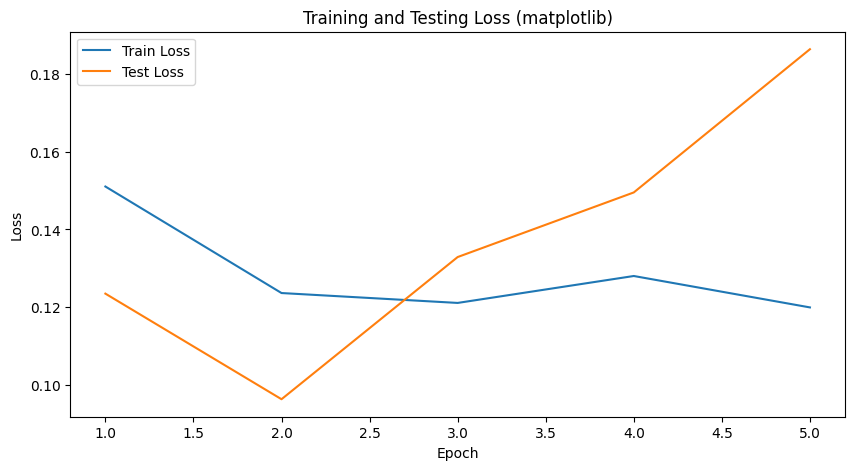

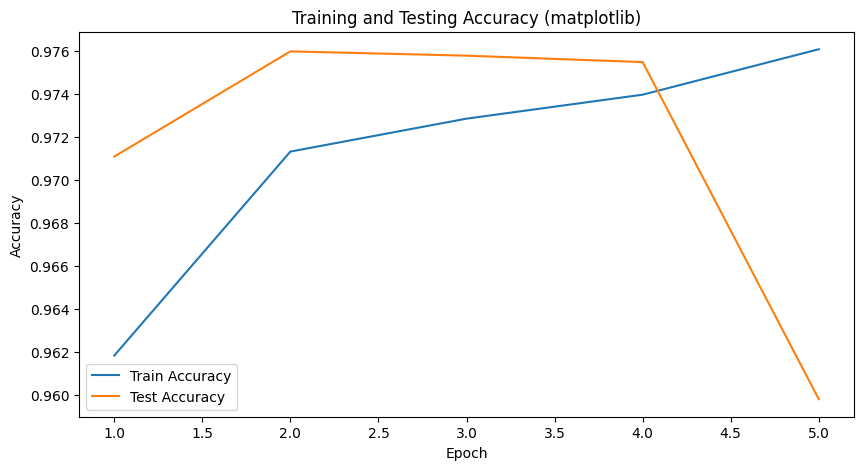

In [22]:
num_epochs = 5
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)

In [47]:
def test_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            # labels_float = labels.float()
            labels = labels.unsqueeze(1).float()
            # print(outputs.shape, labels.shape)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_loss / len(test_loader)
    accuracy = correct / total
    wandb.log({"Test Accuracy": accuracy, "Test Loss": test_loss})
    print(f"Test Loss: {test_loss}, Test Accuracy: {accuracy}")
    return test_loss, accuracy


In [48]:
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=5):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            # print(outputs.shape, labels.unsqueeze(1).float().shape)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_accuracy})
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")

        test_loss, test_accuracy = test_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

    # Plot loss graphs using matplotlib
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss (matplotlib)')
    plt.legend()
    plt.show()

    # Plot accuracy graphs using matplotlib
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy (matplotlib)')
    plt.legend()
    plt.show()

    return train_losses, test_losses


In [ ]:
batch_size = 128
train_loader, test_loader = get_data_loaders(batch_size=batch_size)

model = LeNet().to(device)
wandb.watch(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.08746565882861614, Train Accuracy: 0.056133333333333334


 20%|██        | 1/5 [00:22<01:29, 22.25s/it]

Test Loss: 0.20656793693693493, Test Accuracy: 3.0723
Epoch 2, Train Loss: 0.07819342245012521, Train Accuracy: 0.07893333333333333


 40%|████      | 2/5 [00:45<01:07, 22.66s/it]

Test Loss: 0.19481755947224058, Test Accuracy: 3.0746
Epoch 3, Train Loss: 0.07175539563645919, Train Accuracy: 0.06155


 60%|██████    | 3/5 [01:07<00:45, 22.71s/it]

Test Loss: 0.19374663414606175, Test Accuracy: 3.1256
Epoch 4, Train Loss: 0.06492231627429525, Train Accuracy: 0.10763333333333333


 80%|████████  | 4/5 [01:31<00:23, 23.14s/it]

Test Loss: 0.19368547762032992, Test Accuracy: 3.2776
Epoch 5, Train Loss: 0.05922873932570219, Train Accuracy: 0.10703333333333333


100%|██████████| 5/5 [01:55<00:00, 23.06s/it]

Test Loss: 0.19098891592629183, Test Accuracy: 3.2157


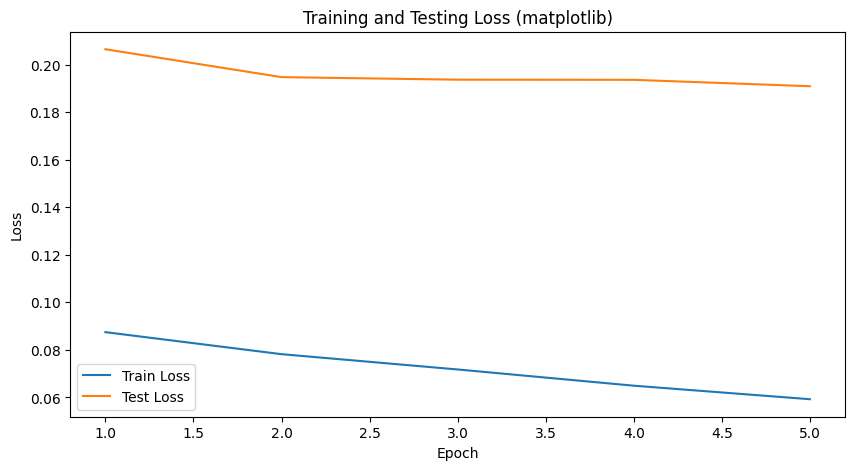

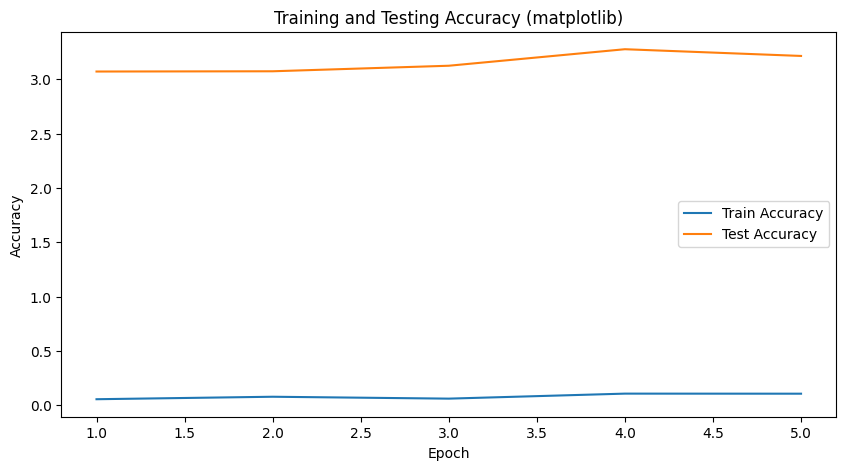

In [49]:
num_epochs = 5
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)

Comparing the best performing CNN against the SIFT-BoVW-SVM approach involves evaluating their performance in terms of accuracy, robustness, and computational efficiency.

Here's a general comparison:

Accuracy: CNNs generally achieve higher accuracy compared to SIFT-BoVW-SVM approaches in image classification tasks. CNNs are able to learn hierarchical features directly from the data, capturing complex patterns and relationships in images, whereas SIFT-BoVW-SVM relies on handcrafted features and a bag-of-words representation, which may not capture as much detail. So best accuracy in SIFT was arounf 70% and in CNN it reached upto 99%

Robustness: CNNs are more robust to variations in the input data such as scale, rotation, and illumination changes, due to their ability to learn features at different levels of abstraction. On the other hand, SIFT-BoVW-SVM approaches may struggle with such variations, as they rely on predefined features and are less adaptive.

Computational Efficiency: SIFT-BoVW-SVM approaches can be computationally expensive, especially when dealing with large datasets or high-dimensional feature spaces. This is because they involve extracting and clustering features, and training an SVM classifier on the resulting histograms. In contrast, while CNNs can be more computationally intensive during training, they can be more efficient during inference, especially with the use of optimized hardware such as GPUs.

In conclusion, while SIFT-BoVW-SVM approaches have been effective in image classification tasks, especially when dealing with smaller datasets or when computational resources are limited, CNNs generally outperform them in terms of accuracy and robustness, albeit at the cost of higher computational requirements during training.

How does the performance change if you double the number of convolutional layers?

Performance remained alomst the same or increased marginally with number of convolutional layers

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 48, 3, padding=1)
        self.fc1 = nn.Linear(48*1*1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 48*1*1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
def get_data_loaders(batch_size=128):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [5]:
def test_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_loss / len(test_loader)
    accuracy = correct / total
    wandb.log({"Test Accuracy": accuracy, "Test Loss": test_loss})
    print(f"Test Loss: {test_loss}, Test Accuracy: {accuracy}")
    return test_loss, accuracy


In [6]:
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=5):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_accuracy})
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")

        test_loss, test_accuracy = test_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accs.append(test_accuracy)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss (matplotlib)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy (matplotlib)')
    plt.legend()
    plt.show()

    return train_losses, test_losses



In [13]:
batch_size = 128
train_loader, test_loader = get_data_loaders(batch_size=batch_size)

model = LeNet().to(device)
wandb.watch(model)

[]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.5079373412612659, Train Accuracy: 0.8282833333333334


 20%|██        | 1/5 [00:18<01:13, 18.38s/it]

Test Loss: 0.1150277312373436, Test Accuracy: 0.9622
Epoch 2, Train Loss: 0.11241929076596109, Train Accuracy: 0.9650833333333333


 40%|████      | 2/5 [00:37<00:56, 18.72s/it]

Test Loss: 0.07717547588686965, Test Accuracy: 0.9735
Epoch 3, Train Loss: 0.07839213214568429, Train Accuracy: 0.97645


 60%|██████    | 3/5 [00:56<00:37, 18.97s/it]

Test Loss: 0.052904211227852806, Test Accuracy: 0.9811
Epoch 4, Train Loss: 0.06202790050554886, Train Accuracy: 0.9807166666666667


 80%|████████  | 4/5 [01:15<00:18, 18.89s/it]

Test Loss: 0.05321430282068993, Test Accuracy: 0.9811
Epoch 5, Train Loss: 0.050304863236046264, Train Accuracy: 0.9844333333333334


100%|██████████| 5/5 [01:33<00:00, 18.77s/it]

Test Loss: 0.038425712260827305, Test Accuracy: 0.9877


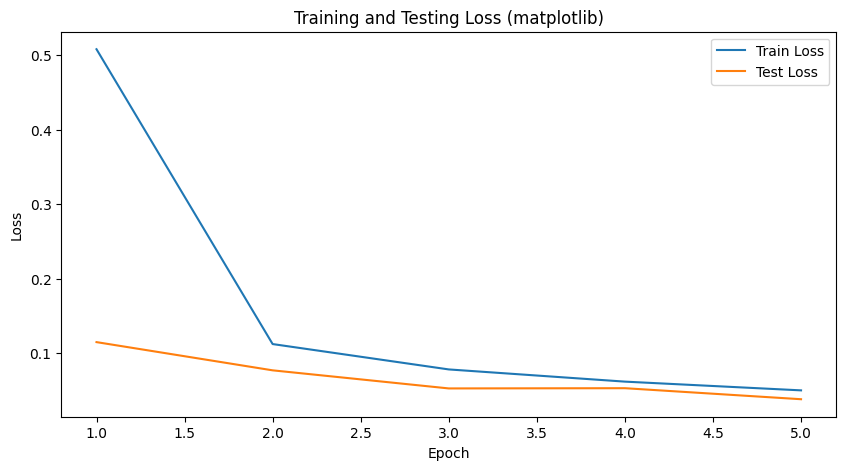

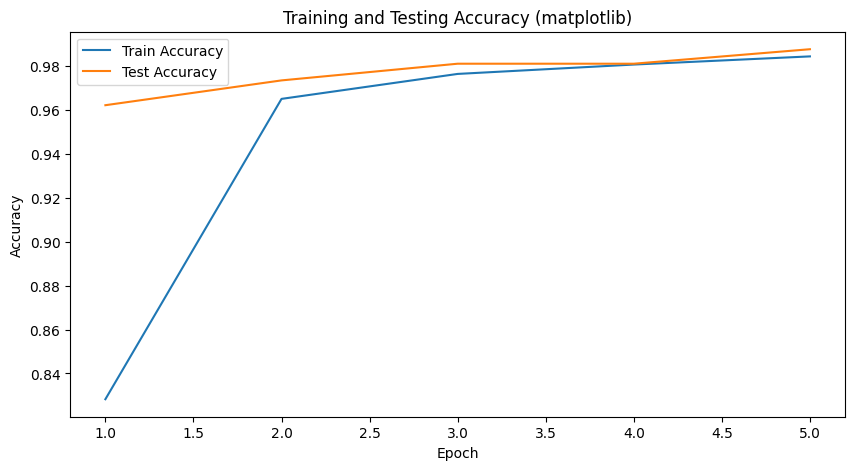

In [93]:
num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)


How does the performance change as you increase the number of training samples: [0.6K, 1.8K, 6K,
18K, 60K]? Explain the trends in classification accuracy that you observe.


Accuracy increased continuously with the increase in dataset.

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import numpy as np

def get_data_loaders(num_samples, batch_size=128, test_size=0.1):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Randomly select num_samples samples for training
    indices = np.random.choice(len(train_set), num_samples, replace=False)
    train_set = Subset(train_set, indices)

    # Split the training set into training and test sets
    num_test_samples = int(len(train_set) * test_size)
    num_train_samples = len(train_set) - num_test_samples
    train_set, test_set = torch.utils.data.random_split(train_set, [num_train_samples, num_test_samples])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [96]:
num_samples = 600
train_loader, test_loader = get_data_loaders(num_samples, batch_size=batch_size)


In [97]:
num_samples_train = len(train_loader.dataset)
num_samples_test = len(test_loader.dataset)

print("Number of training samples:", num_samples_train)
print("Number of test samples:", num_samples_test)


Number of training samples: 540
Number of test samples: 60


 40%|████      | 2/5 [00:00<00:00,  4.11it/s]

Epoch 1, Train Loss: 2.2977155685424804, Train Accuracy: 0.11296296296296296
Test Loss: 2.3019492626190186, Test Accuracy: 0.06666666666666667
Epoch 2, Train Loss: 2.2940811634063722, Train Accuracy: 0.11481481481481481
Test Loss: 2.2968060970306396, Test Accuracy: 0.15


 80%|████████  | 4/5 [00:00<00:00,  5.12it/s]

Epoch 3, Train Loss: 2.290591096878052, Train Accuracy: 0.2111111111111111
Test Loss: 2.2868754863739014, Test Accuracy: 0.16666666666666666
Epoch 4, Train Loss: 2.2711090564727785, Train Accuracy: 0.22962962962962963
Test Loss: 2.2599143981933594, Test Accuracy: 0.35


100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


Epoch 5, Train Loss: 2.228226137161255, Train Accuracy: 0.32592592592592595
Test Loss: 2.200627088546753, Test Accuracy: 0.35


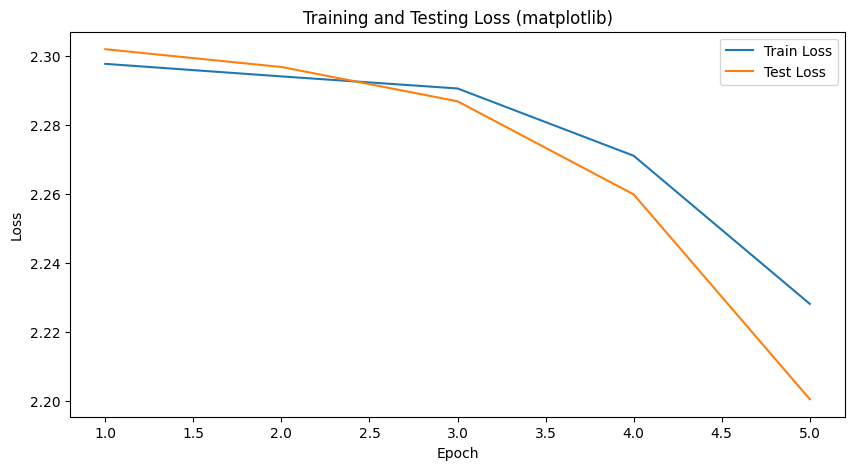

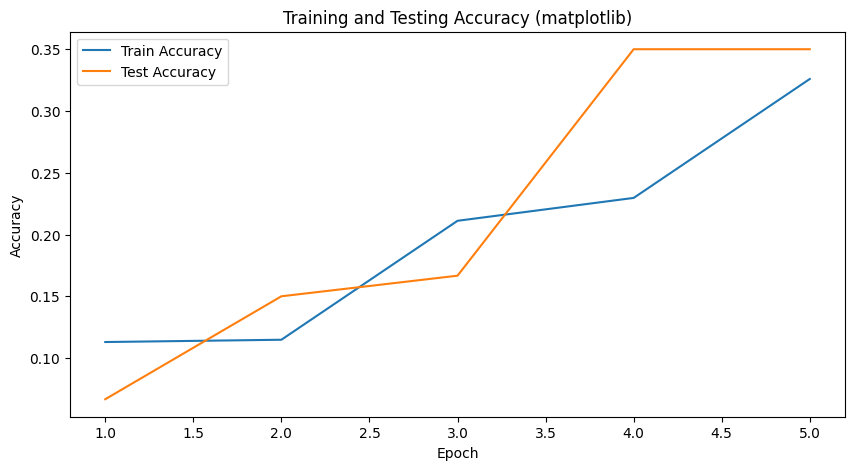

In [99]:
model = LeNet().to(device)
wandb.watch(model)

num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)


In [ ]:
# [0.6K, 1.8K, 6K,
# 18K, 60K]

 20%|██        | 1/5 [00:00<00:02,  1.54it/s]

Epoch 1, Train Loss: 2.2946753318493185, Train Accuracy: 0.15617283950617283
Test Loss: 2.2898772954940796, Test Accuracy: 0.17222222222222222


 40%|████      | 2/5 [00:01<00:02,  1.40it/s]

Epoch 2, Train Loss: 2.193554162979126, Train Accuracy: 0.27530864197530863
Test Loss: 2.0166683197021484, Test Accuracy: 0.3388888888888889


 60%|██████    | 3/5 [00:01<00:01,  1.66it/s]

Epoch 3, Train Loss: 1.7703127952722402, Train Accuracy: 0.4
Test Loss: 1.4712218642234802, Test Accuracy: 0.49444444444444446


 80%|████████  | 4/5 [00:02<00:00,  1.78it/s]

Epoch 4, Train Loss: 1.3818677205305834, Train Accuracy: 0.5172839506172839
Test Loss: 1.1931465864181519, Test Accuracy: 0.6055555555555555


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

Epoch 5, Train Loss: 1.1869850250390859, Train Accuracy: 0.5679012345679012
Test Loss: 1.0177690386772156, Test Accuracy: 0.6277777777777778


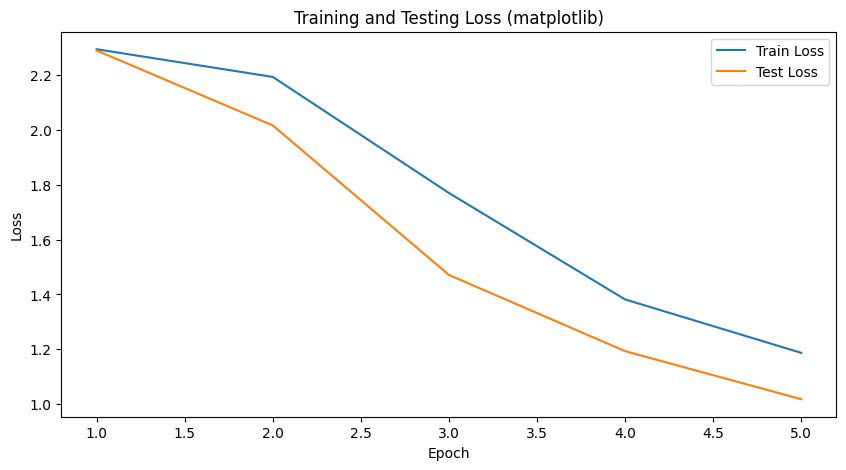

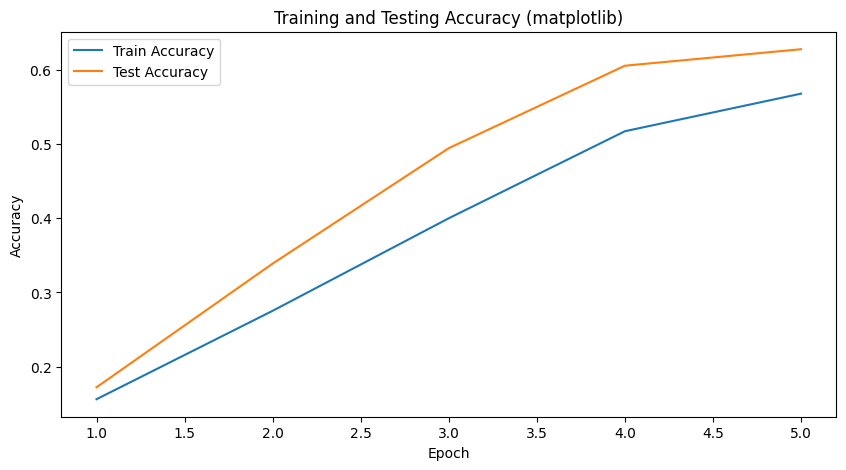

In [100]:
num_samples = 1800
train_loader, test_loader = get_data_loaders(num_samples, batch_size=batch_size)

model = LeNet().to(device)
wandb.watch(model)

num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)

 20%|██        | 1/5 [00:01<00:07,  1.87s/it]

Epoch 1, Train Loss: 2.144678279410961, Train Accuracy: 0.1975925925925926
Test Loss: 1.6343023538589478, Test Accuracy: 0.4816666666666667


 40%|████      | 2/5 [00:03<00:05,  1.68s/it]

Epoch 2, Train Loss: 1.2677879264188368, Train Accuracy: 0.5672222222222222
Test Loss: 0.8631465673446655, Test Accuracy: 0.7266666666666667


 60%|██████    | 3/5 [00:05<00:03,  1.65s/it]

Epoch 3, Train Loss: 0.6655886797017829, Train Accuracy: 0.7716666666666666
Test Loss: 0.511691403388977, Test Accuracy: 0.8433333333333334
Epoch 4, Train Loss: 0.41869297034518665, Train Accuracy: 0.8612962962962963


 80%|████████  | 4/5 [00:06<00:01,  1.66s/it]

Test Loss: 0.3845393121242523, Test Accuracy: 0.8783333333333333
Epoch 5, Train Loss: 0.2868344891209935, Train Accuracy: 0.9144444444444444


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]

Test Loss: 0.25453962981700895, Test Accuracy: 0.9166666666666666


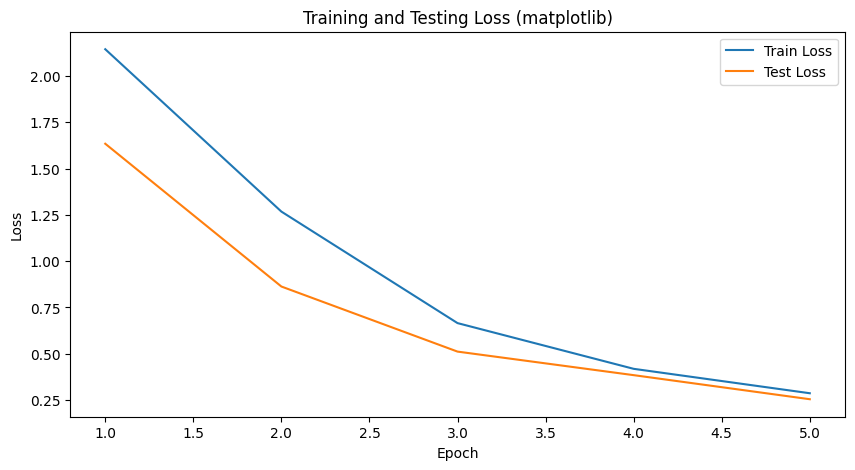

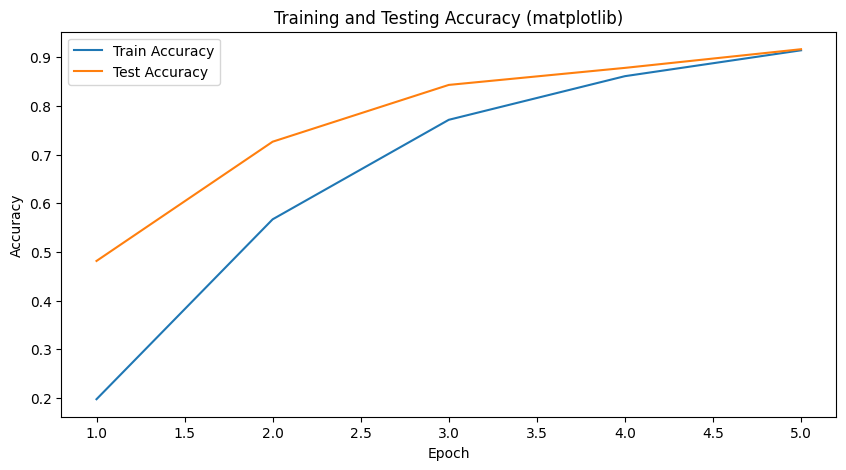

In [101]:
num_samples = 6000
train_loader, test_loader = get_data_loaders(num_samples, batch_size=batch_size)

model = LeNet().to(device)
wandb.watch(model)

num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Loss: 1.2436934458458517, Train Accuracy: 0.5614814814814815


 20%|██        | 1/5 [00:07<00:28,  7.23s/it]

Test Loss: 0.4815568566322327, Test Accuracy: 0.8566666666666667
Epoch 2, Train Loss: 0.32508540787096096, Train Accuracy: 0.8960493827160494


 40%|████      | 2/5 [00:11<00:17,  5.69s/it]

Test Loss: 0.25349449217319486, Test Accuracy: 0.9166666666666666
Epoch 3, Train Loss: 0.1829456542655239, Train Accuracy: 0.942283950617284


 60%|██████    | 3/5 [00:17<00:10,  5.47s/it]

Test Loss: 0.1601240297158559, Test Accuracy: 0.95
Epoch 4, Train Loss: 0.13739294124635185, Train Accuracy: 0.9579012345679012


 80%|████████  | 4/5 [00:21<00:05,  5.13s/it]

Test Loss: 0.13188009535272915, Test Accuracy: 0.9588888888888889
Epoch 5, Train Loss: 0.11231271822856168, Train Accuracy: 0.9649382716049383


100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

Test Loss: 0.0999062679708004, Test Accuracy: 0.9683333333333334


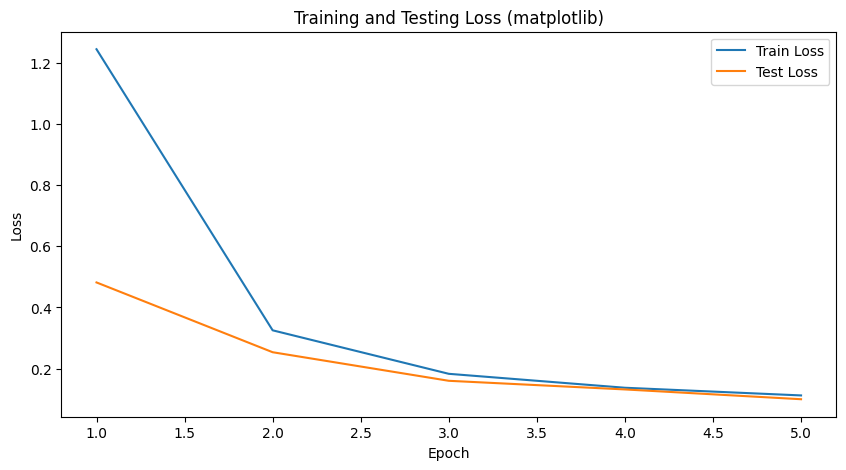

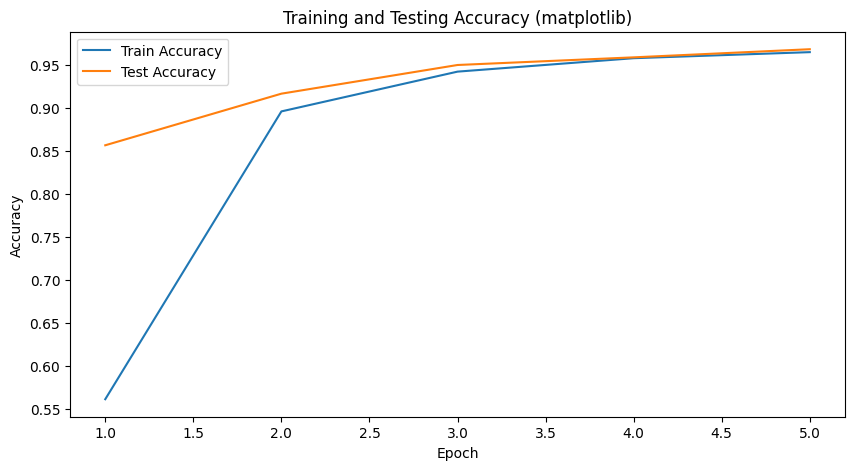

In [102]:
num_samples = 18000
train_loader, test_loader = get_data_loaders(num_samples, batch_size=batch_size)

model = LeNet().to(device)
wandb.watch(model)

num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.505513336633054, Train Accuracy: 0.8326851851851852


 20%|██        | 1/5 [00:16<01:07, 16.87s/it]

Test Loss: 0.12880016982238343, Test Accuracy: 0.9631666666666666
Epoch 2, Train Loss: 0.11684688325017974, Train Accuracy: 0.9643333333333334


 40%|████      | 2/5 [00:33<00:49, 16.48s/it]

Test Loss: 0.09892797763360307, Test Accuracy: 0.97
Epoch 3, Train Loss: 0.07901400915607457, Train Accuracy: 0.9756666666666667


 60%|██████    | 3/5 [00:50<00:33, 16.85s/it]

Test Loss: 0.06954344750401821, Test Accuracy: 0.9795
Epoch 4, Train Loss: 0.0648849195181679, Train Accuracy: 0.9797962962962963


 80%|████████  | 4/5 [01:06<00:16, 16.54s/it]

Test Loss: 0.06767498948512242, Test Accuracy: 0.9805
Epoch 5, Train Loss: 0.05332880780118478, Train Accuracy: 0.9833148148148149


100%|██████████| 5/5 [01:24<00:00, 16.87s/it]

Test Loss: 0.061411865451868546, Test Accuracy: 0.9833333333333333


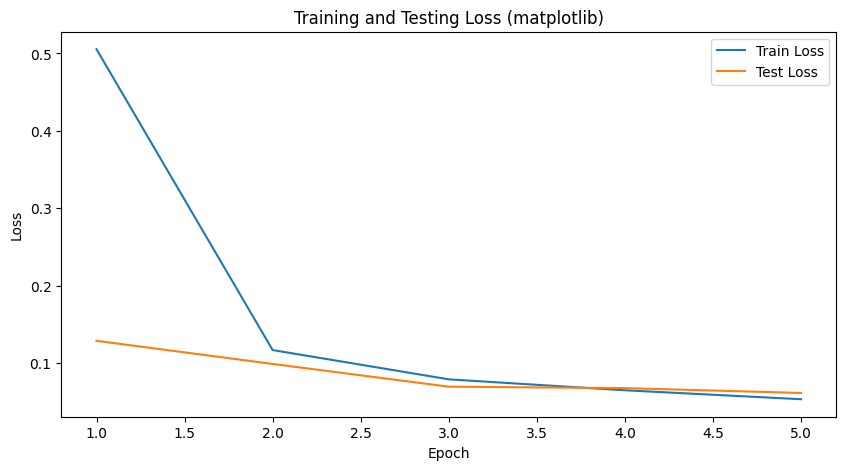

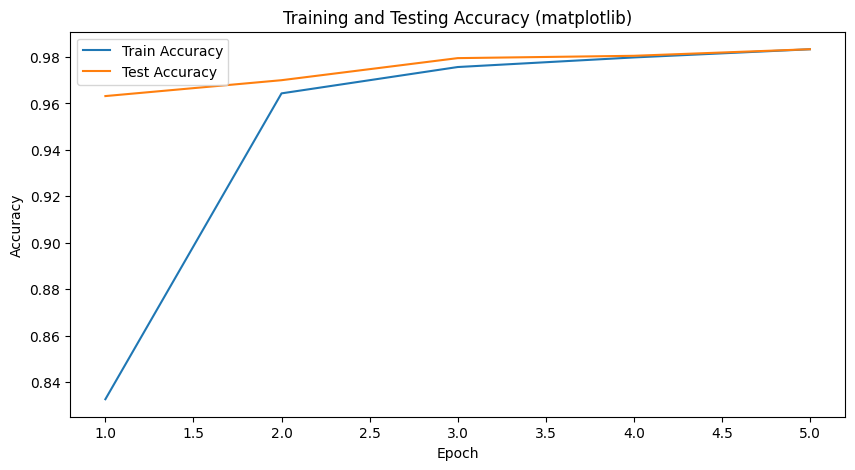

In [103]:
num_samples = 60000
train_loader, test_loader = get_data_loaders(num_samples, batch_size=batch_size)

model = LeNet().to(device)
wandb.watch(model)

num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)

Replace the CNN model with a 2 layer TransformerEncoder. Using a ViT style prediction scheme,
evaluate classification accuracy when training with 6K and 60K images. How do the results compare against
CNNs? Explain the trends.

It performed better than CNN based approach in the starting epochs but latter VIT perrformed slightly better

In [48]:
def get_data_loaders(num_samples, batch_size=128):
    transform = transforms.Compose([
        transforms.Resize((8, 8)),  
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Choose random samples for the train set
    indices = np.random.choice(len(train_set), size=num_samples, replace=False)
    train_set = torch.utils.data.Subset(train_set, indices)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [49]:
class ViTStyleModel(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=512, num_classes=10, num_layers=2, num_heads=8, ff_dim=2048, dropout=0.1):
        super(ViTStyleModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x.view(-1, 8*8))
        x = x.view(x.size(0), 1, -1)  # to add a channel dimension
        x = x.permute(1, 0, 2)  # to (seq_len, batch_size, hidden_dim) for Transformer
        x = self.encoder(x)
        x = x.mean(dim=0) 
        x = self.fc(x)
        return x


In [50]:
num_samples = 6000
batch_size=128
train_loader, test_loader = get_data_loaders(num_samples, batch_size=batch_size)

model = ViTStyleModel().to(device)
wandb.watch(model)
print(model)


ViTStyleModel(
  (embedding): Linear(in_features=64, out_features=512, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Loss: 1.2495197165519634, Train Accuracy: 0.6255


 20%|██        | 1/5 [00:04<00:19,  4.83s/it]

Test Loss: 0.45686842831252494, Test Accuracy: 0.8596
Epoch 2, Train Loss: 0.47516769107351914, Train Accuracy: 0.847


 40%|████      | 2/5 [00:09<00:13,  4.50s/it]

Test Loss: 0.32001755363013173, Test Accuracy: 0.8993
Epoch 3, Train Loss: 0.36914776455848775, Train Accuracy: 0.8868333333333334


 60%|██████    | 3/5 [00:13<00:08,  4.40s/it]

Test Loss: 0.3038814935503127, Test Accuracy: 0.9036
Epoch 4, Train Loss: 0.29336195217168076, Train Accuracy: 0.9081666666666667


 80%|████████  | 4/5 [00:18<00:04,  4.55s/it]

Test Loss: 0.3191549553052534, Test Accuracy: 0.8962
Epoch 5, Train Loss: 0.29137120665387906, Train Accuracy: 0.9108333333333334


100%|██████████| 5/5 [00:22<00:00,  4.49s/it]

Test Loss: 0.27004955968336214, Test Accuracy: 0.9168


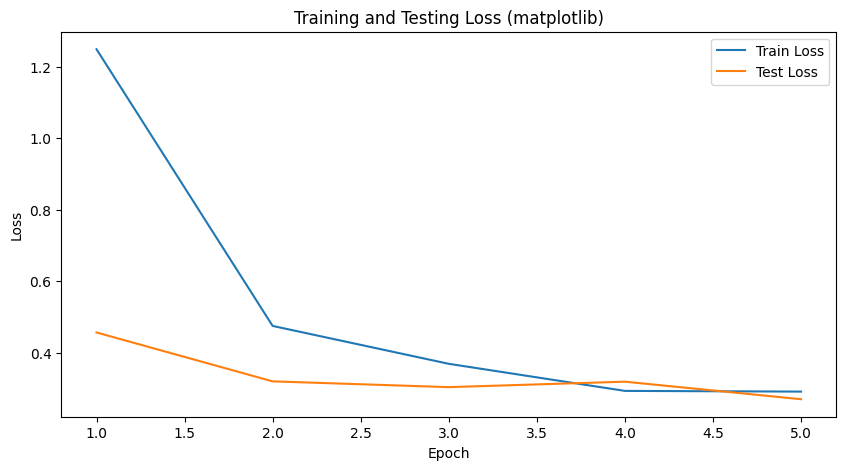

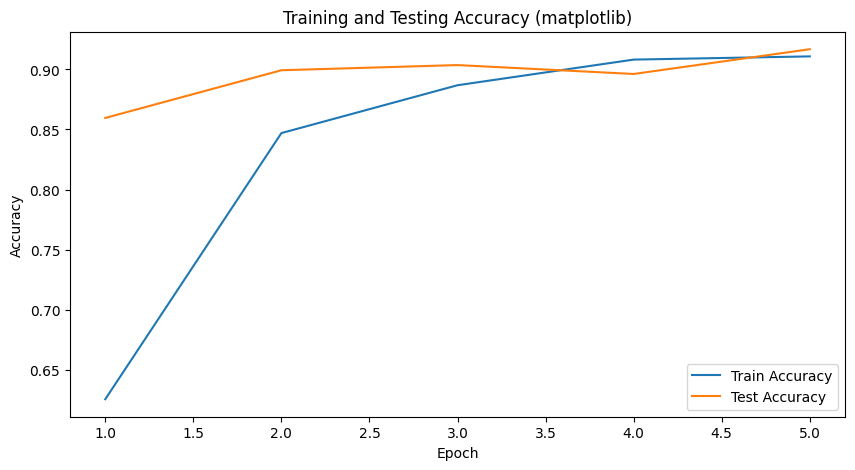

In [51]:
num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.5725635582519368, Train Accuracy: 0.8051666666666667


 20%|██        | 1/5 [00:16<01:05, 16.45s/it]

Test Loss: 0.17993153457311875, Test Accuracy: 0.9448333333333333
Epoch 2, Train Loss: 0.1311656100790224, Train Accuracy: 0.9594444444444444


 40%|████      | 2/5 [00:32<00:49, 16.42s/it]

Test Loss: 0.1283782220425758, Test Accuracy: 0.9651666666666666
Epoch 3, Train Loss: 0.0898455204309728, Train Accuracy: 0.9726851851851852


 60%|██████    | 3/5 [00:49<00:33, 16.58s/it]

Test Loss: 0.09312332171867503, Test Accuracy: 0.9741666666666666
Epoch 4, Train Loss: 0.06993130783404784, Train Accuracy: 0.9784444444444444


 80%|████████  | 4/5 [01:05<00:16, 16.41s/it]

Test Loss: 0.09230622609562063, Test Accuracy: 0.9731666666666666
Epoch 5, Train Loss: 0.05718634181580908, Train Accuracy: 0.9824259259259259


100%|██████████| 5/5 [01:21<00:00, 16.39s/it]

Test Loss: 0.07130339311713234, Test Accuracy: 0.9773333333333334


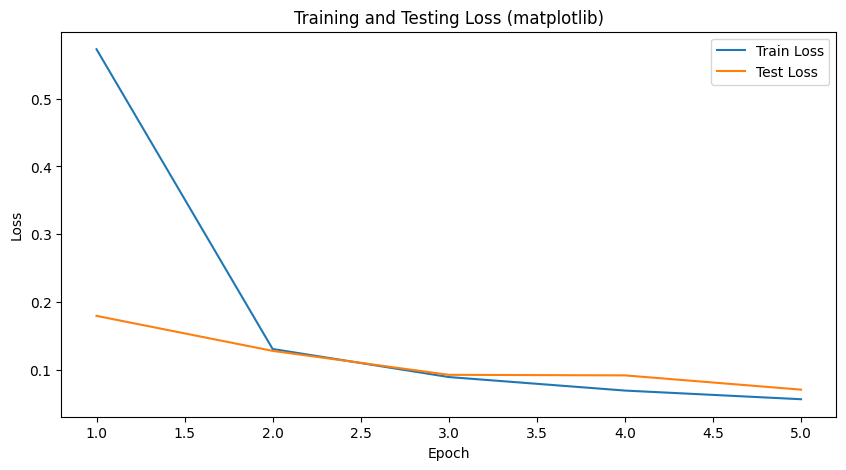

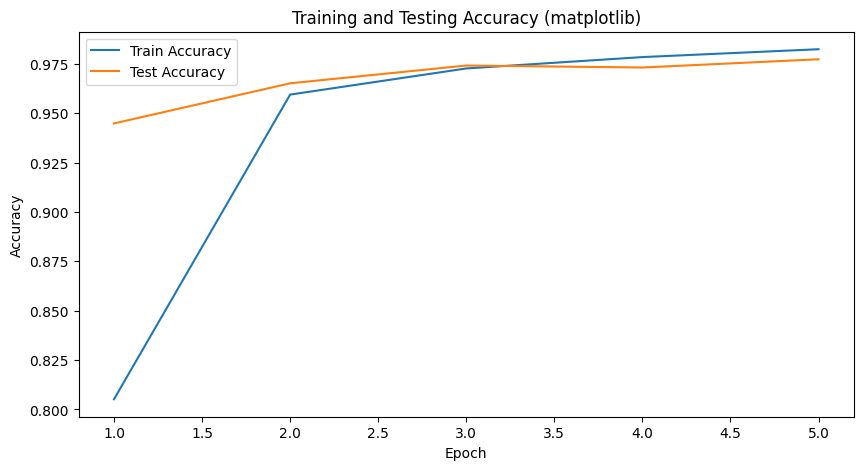

In [106]:
num_samples = 60000
train_loader, test_loader = get_data_loaders(num_samples, batch_size=batch_size)

model = ViTStyleModel().to(device)
# wandb.watch(model)

num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)

Challenges :

1) Knowing all the functions of CNN


2) Playing with hyperparameters and get to know the reasoning behind the changes.